In [1]:
library(ggplot2)
library(reshape2)

## Panel A - XX


In [ ]:
# @SARAH to do

## Panel B

Using varname as id variables


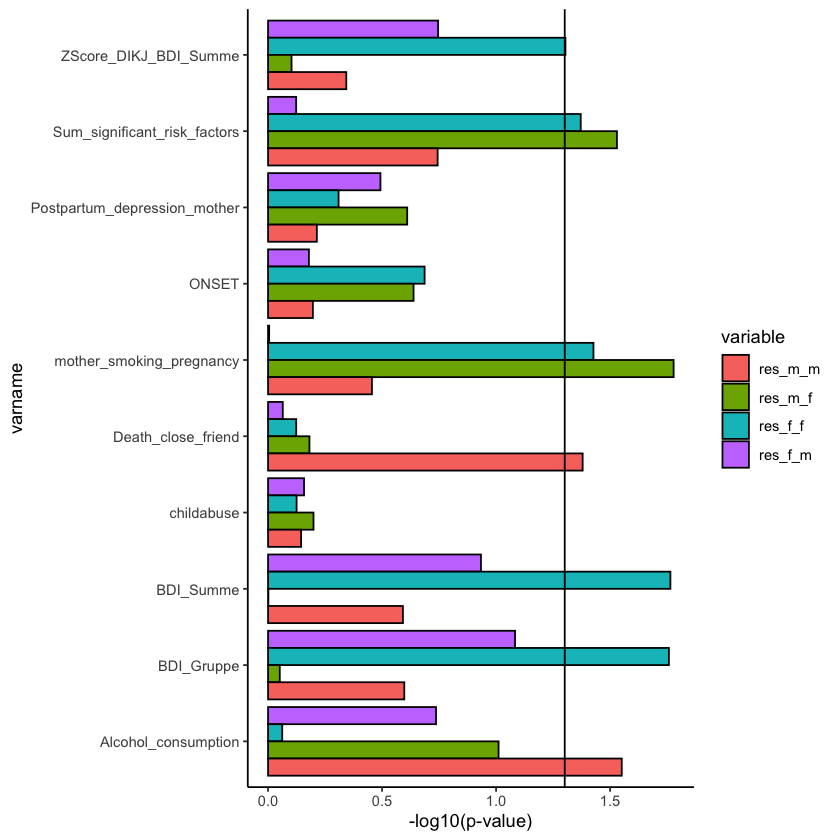

In [2]:
data.trps <- readRDS(file="data/fig4B_cohort1_TRPS_results.rds")
data.trps.log <- cbind(data.trps$varname,-log10(data.trps [,c(2,3,5,4)]))
colnames(data.trps.log)[1] <- "varname"
data.trps.log.melt <- melt(data.trps.log )

#pdf("Figure4B_barplot.pdf")
ggplot(data.trps.log.melt, aes(x = varname, y=value,fill=variable)) +
  geom_bar(stat="identity", colour="black", position=position_dodge())+geom_hline(yintercept = -log10(0.05))+
  coord_flip()+theme_classic()+ylab("-log10(p-value)")
#dev.off()


## Panel C-D

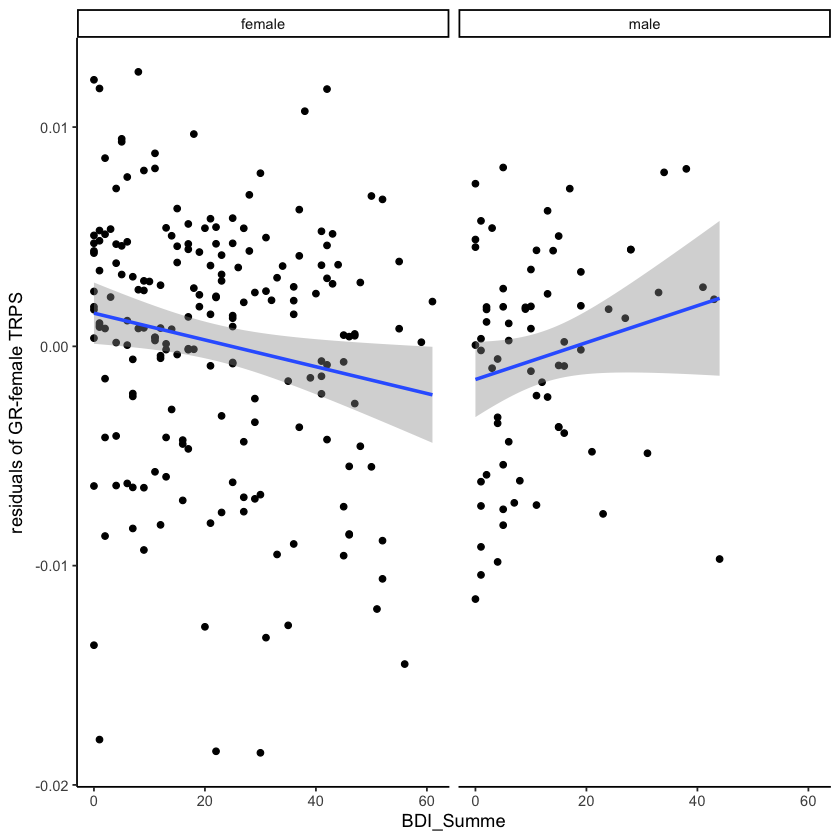

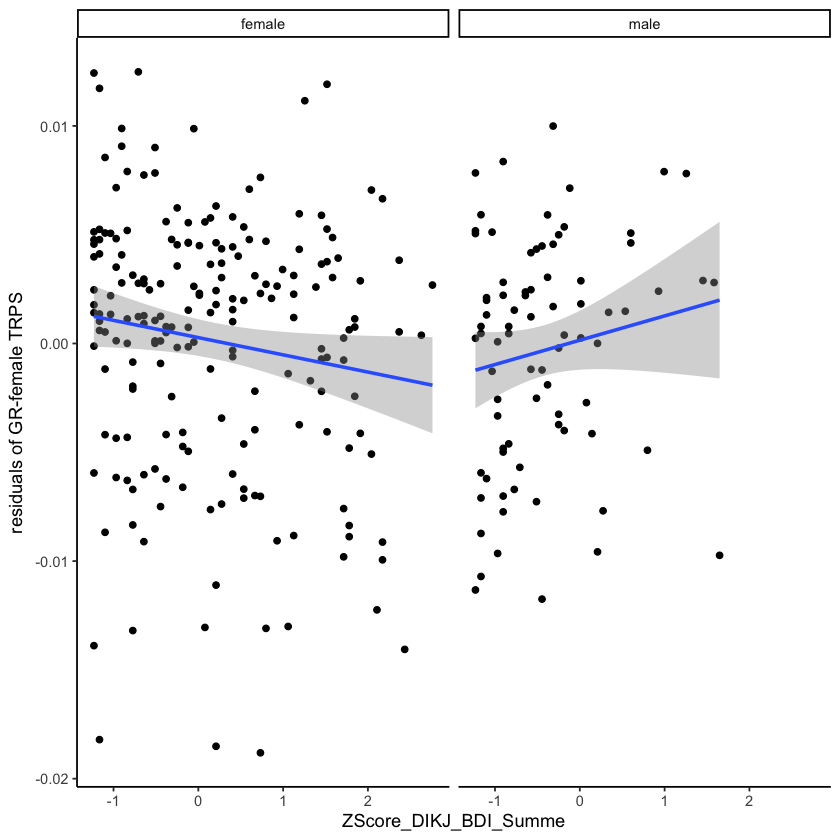

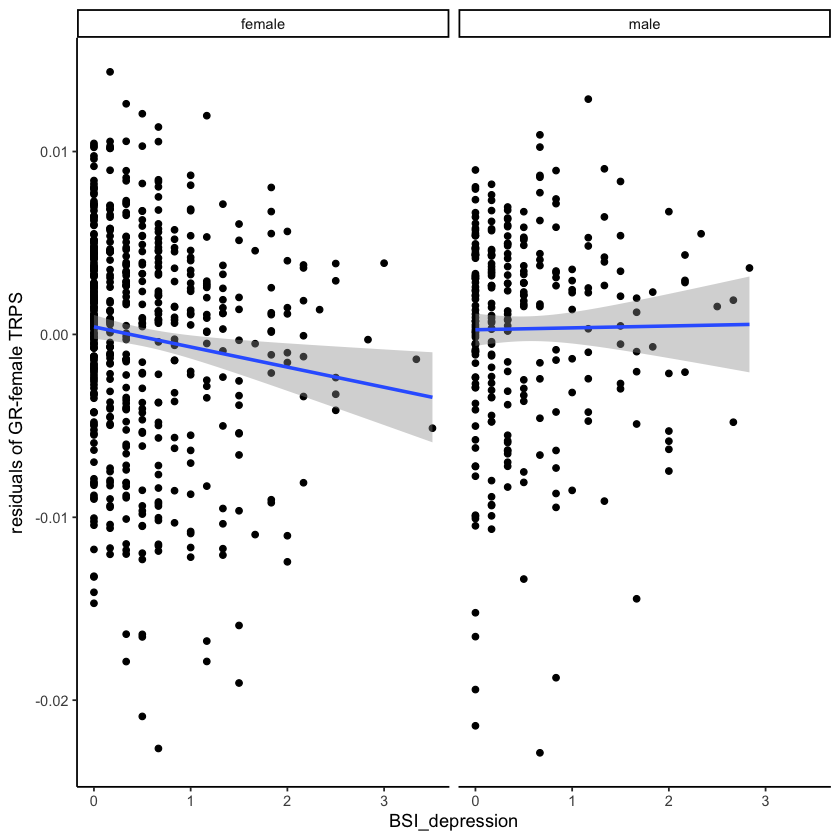

In [3]:
#pdf("BSI_female.pdf")
cohort1.bdi <- readRDS("data/fig4C_cohort1_TRPS_BDI.rds")
cohort1.bdi$sex  = "male"
cohort1.bdi[ cohort1.bdi$FB_K01_J01_Geschl %in% 0,]$sex="female"

cohort1.zscore <- readRDS("data/fig4C_cohort1_TRPS_Zscore.rds")
cohort1.zscore$sex  = "male"
cohort1.zscore[ cohort1.zscore$FB_K01_J01_Geschl %in% 0,]$sex="female"

cohort2.bsi <- readRDS("data/fig4C_cohort2_TRPS.rds")
cohort2.bsi$sex  = "male"
cohort2.bsi [ cohort2.bsi$GENERO %in% 2,]$sex="female"

#pdf("Figure4C_depression_status.pdf")
qplot(x =BDI_Summe  , y = residuals,  facets = ~sex, data = cohort1.bdi,na.rm = TRUE) +
  geom_smooth(method = "lm")+theme_classic()+ylab("residuals of GR-female TRPS")
qplot(x = ZScore_DIKJ_BDI_Summe  , y = residuals,  facets = ~sex, data = cohort1.zscore ,na.rm = TRUE) +
  geom_smooth(method = "lm")+theme_classic()+ylab("residuals of GR-female TRPS")
qplot(x =BSI_depression  , y = residuals,  facets = ~sex, data = cohort2.bsi,na.rm = TRUE) +
  geom_smooth(method = "lm")+theme_classic()+ylab("residuals of GR-female TRPS")
#dev.off()


## Panel E - PGC enrichment

Using varname as id variables


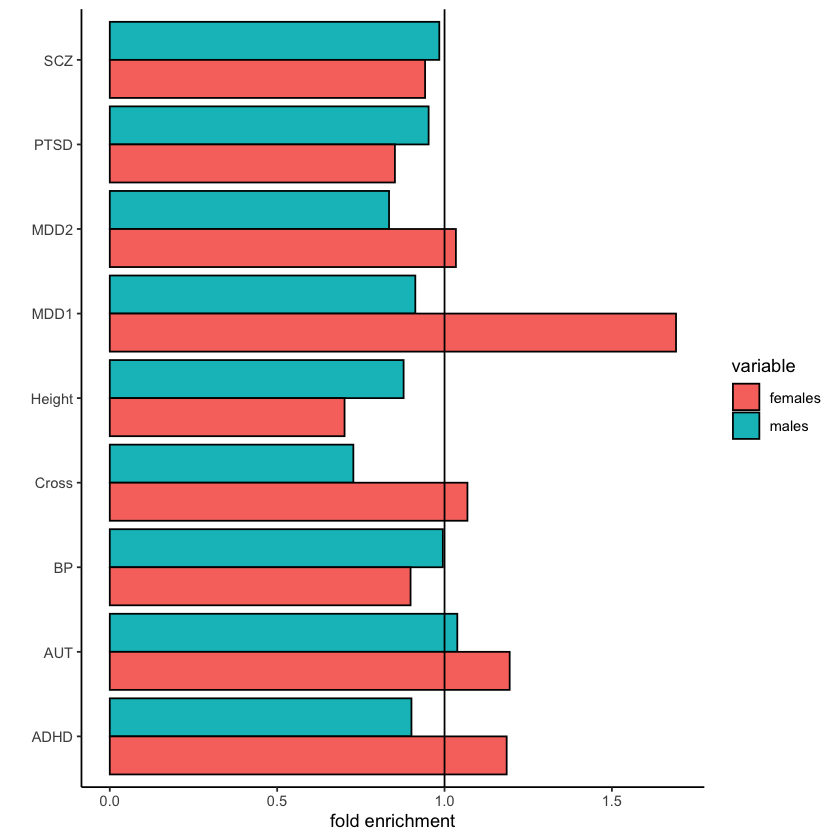

In [4]:
pVal <- readRDS("data/fig4E_PGC_TRPS_results_pVal.rds")
or <- readRDS("data/fig4E_PGC_TRPS_results_or.rds")

or.t <- as.data.frame(t(or)) 
or.t$varname <- row.names(or.t)
or.t.melt <- melt(or.t)

#pdf("Figure4E_pgc.pdf")
ggplot(or.t.melt , aes(x = varname, y=value,fill=variable)) +
  geom_bar(stat="identity", colour="black", position=position_dodge())+geom_hline(yintercept = 1)+
  coord_flip()+theme_classic()+ylab("fold enrichment")+xlab("")
#dev.off()
